In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import pandas_ta as ta
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

In [3]:
%run DAINONLYCODE.ipynb

In [4]:
def bc(col):
    fitted_data, fitted_lambda = stats.boxcox(col)
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data
    
def plot_box_cox(col):
    fitted_data, fitted_lambda = stats.boxcox(col)
    
    fig, ax = plt.subplots(1, 2)
    sns.distplot(col, hist = False, kde = True,
               kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)

    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data

def minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def meansd(col):
    return (col - col.mean())/col.std()

def parse_binance_data(filename):
    # https://www.cryptodatadownload.com/data/binance/
    df = pd.read_csv(filename, skiprows = 1)
    return df.loc[:,["close","high","date"]]

def plot_2(x, y1, y2, lab1, lab2, title, mode = ""):
    plt.rcParams["figure.figsize"] = (20,7)
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(20)
    ax.plot(x, y1,color = "#1f77b4", alpha = 1, label = lab1)
    ax2=ax.twinx()
    ax2.plot(x, y2,color="#ff7f0e", alpha = 0.5, label = lab2)
    plt.title(title)
    if mode == "mosc":
        ax2.axhspan(-10, -14, facecolor='#FF6962', alpha=0.3)
        ax2.axhspan(10, 14, facecolor='#77DD76', alpha=0.3)
        
    if mode == "wpo":
        ax2.axhspan(-2.7, -2, facecolor='#FF6962', alpha=0.3)
        ax2.axhspan(-2, 0, facecolor='#FF6962', alpha=0.1)
        ax2.axhspan(0, 2, facecolor='#77DD76', alpha=0.1)
        ax2.axhspan(2, 2.7, facecolor='#77DD76', alpha=0.3)
        
    if mode == "shi":
        ax2.axhspan(min(y2), 0, facecolor='#FF6962', alpha=0.1)
        ax2.axhspan(0, max(y2), facecolor='#77DD76', alpha=0.1)
    
    if mode == "sho":
        ax2.axhspan(-100, -40, facecolor='#FF6962', alpha=0.2)
        ax2.axhspan(-40, 0, facecolor='#FF6962', alpha=0.1)
        ax2.axhspan(0, 40, facecolor='#77DD76', alpha=0.1)
        ax2.axhspan(40, 100, facecolor='#77DD76', alpha=0.2)
        
    plt.legend()
    plt.show()

def plot_3(x,y,z,w, title, lab1, lab2, lab3, mosc = False):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    p1, = host.plot(x, y, label = lab1)
    p2, = par1.plot(x, z, label = lab2, alpha=0.5)
    if mosc:
        par1.axhspan(-10, -14, facecolor='#FF6962', alpha=0.3)
        par1.axhspan(10, 14, facecolor='#77DD76', alpha=0.3)
    p3, = par2.plot(x, w, label = lab3, alpha=0.5)
    host.legend()
    

    plt.title(title)
    plt.draw()
    plt.show()
    
def ema(col, window):
    return ta.ema(col, length=window)

def add_mosc(data):
    df = data.copy()
    df.loc[:,"quantization"] = -15
    for index in range(0, len(df) - 14):
        t = df.close[index]
        quantization = 0
        for i in df.close[index + 1:index + 15]:
            if t > i:
                quantization+=1
            if t < i:
                quantization-=1
        df.loc[index,"quantization"] = quantization
    df = df[::-1]
    df["mosc"] = ema(ema(df.quantization, 5),3)
    df["sline"] = ema(df.mosc,3)
    df = df[::-1]
    return df

def add_wpo(data):
    df = data.copy()
    df["sin_angle"] = df.close/df.high
    df["angle_radians"] = np.arcsin(df.sin_angle)
    df["shifted"] = df.close.div(df.close.shift(), axis=0).fillna(1.1)
    df["T"] = [6.28/i if (j > 1 or j == np.nan) else -6.28/i for i,j in zip(df.angle_radians, df.shifted)]
    df = df[::-1]
    df["wpo"] = ema(df["T"], 14)
    df = df[::-1]
    return df

def at(col):
    return (col[0] - col[1]) - (col[1] - col[2])

def add_shi(data, clean = False):
    df = data.copy()
    df["at"] = np.nan
    df["y"] = np.nan
    for index in range(0, len(df) - 2):
            df.loc[index, "at"] = at(np.array(df.close[index :index + 3]))
            ccy = np.array(df.close[index :index + 2])
            df.loc[index, "y"] = ccy[0] - ccy[1]
    df = df[::-1]
    df["a"] = ema(df["at"], 14)
    df = df[::-1]
    
    df.loc[:,"T"] = 2*np.pi*np.sqrt(abs(df["y"]/df["a"]))
    df["Ti"] = np.nan
    for index in range(0, len(df)):
        if df.loc[index, "y"] < 0:
            df.loc[index, "Ti"] = -df.loc[index, "T"]
        else:
            df.loc[index, "Ti"] = df.loc[index, "T"]
            
    df = df[::-1]
    df["SHI"] = ema(df["Ti"], 14)
    df = df[::-1]
    if clean == True:
        return df[["close","date","T", "Ti"]]
    return df

def add_sho(data):
    df = data.copy()
    sho = add_shi(df, clean = False)
    sho = sho[::-1]
    sho["VP"] = ema(sho["Ti"], 14)
    sho["TP"] = ema(sho["T"], 14)
    sho = sho[::-1]
    sho["SHO"] = 100*sho["VP"]/sho["TP"]
    return sho

def replace_close_minmax(data):
    df = data.copy()
    df["close"] = minmax(df.close)
    df["high"] = minmax(df.high)
    df.close = df.close.replace(0,0.000001)
    df.high = df.high.replace(0,0.000001)
    return df
    
def replace_close_meansd(data):
    df = data.copy()
    df["close"] = meansd(df.close)
    df["high"] = meansd(df.high)
    return df
    

def add_dain(data):
    df = data.copy()
    df["close"] = to_dain(df.close)
    df["high"] = to_dain(df.high)
    return df
    
def add_bc(data):
    df = data.copy()
    df["close"] = bc(df.close)
    df["high"] = bc(df.high)
    return df
    
    
def plot_osc_on_normalised(osctype, df):
    if osctype == "mosc":
        
        print("Normal")
        mosc = add_mosc(df)
        plot_2(mosc.index[::-1], mosc.realclose, mosc.mosc,"MOSC(Returns)","Close", "MOSC(Returns) vs Close", "mosc")
        """
        print("BOXCOX")
        bcmosc = add_mosc(add_bc(df))
        plot_2(bcmosc.index[::-1], bcmosc.realclose, bcmosc.mosc,"MOSC(BOXCOX(Returns))","Close", "MOSC(BOXCOX(Returns)) vs Close", "mosc")
        
        print("DAIN")
        moscdain = add_dain(df)
        moscdain = add_mosc(moscdain)
        plot_2(moscdain.index[::-1], moscdain.realclose, moscdain.mosc,"MOSC(Returns)","Close", "MOSC(Returns) vs Close", "mosc")
        
        print("MINMAX")
        minmax_mosc = replace_close_minmax(df)
        minmax_mosc = add_mosc(minmax_mosc)
        plot_3( minmax_mosc.index[::-1], minmax_mosc.mosc, minmax_mosc.mosc, minmax_mosc.mosc, "", "close", "mosc", "sline" , True)
        plot_2(mosc.index[::-1], mosc.realclose, mosc.mosc,"MOSC(Returns)","Close", "MOSC(Returns) vs Close", "mosc")
        
        print("MEANSD")
        meansd_mosc = replace_close_meansd(df)
        meansd_mosc = add_mosc(meansd_mosc)
        plot_3(meansd_mosc.index[::-1], meansd_mosc.mosc, meansd_mosc.mosc, meansd_mosc.mosc, "", "close", "mosc", "sline" , True)
        plot_2(mosc.index[::-1], mosc.realclose, mosc.mosc,"MOSC(Returns)","Close", "MOSC(Returns) vs Close", "mosc")
        """
        
    if osctype == "wpo":
        print("Normal")
        wpo = add_wpo(df) 
        plt.figure()
        plot_2(wpo.index[::-1], wpo.realclose, wpo.wpo,"Returns","WPO", "Returns vs WPO", "wpo")
        
        print("BOXCOX")
        bcwpo = add_wpo(add_bc(df))
        plot_2(bcwpo.index[::-1], bcwpo.realclose, bcwpo.wpo,"Returns","WPO", "Returns vs WPO", "wpo")

    
    if osctype == "shi":
        print("Normal")
        shi = add_shi(df)
        plot_2(shi.index[::-1], shi.realclose, shi.SHI,"Returns","SHI", "Returns vs SHI", "shi")
        
        print("BOXCOX")
        bcshi = add_shi(add_bc(df))
        plot_2(bcshi.index[::-1], bcshi.realclose, bcshi.SHI,"Returns","SHI", "Returns vs SHI", "shi")
        
        """
        print("DAIN")
        shidain = add_dain(df)
        shidain = add_shi(shidain)
        plot_2(shidain.index[::-1], shidain.realclose, shidain.SHI,"Close","DAIN", "Close vs DAIN", "shi")
        print("MINMAX")
        minmax_shi = replace_close_minmax(df)
        minmax_shi = add_shi(minmax_shi)
        plot_2(minmax_shi.index[::-1], minmax_shi.realclose, minmax_shi.SHI,"Close","MINMAX", "Close vs MINMAX", "shi")
        print("MEANSD")
        meansd_shi = replace_close_meansd(df)
        meansd_shi = add_shi(meansd_shi)
        plot_2(meansd_shi.index[::-1], meansd_shi.realclose, meansd_shi.SHI,"Close","MEANSD", "Close vs MEANSD", "shi")
        """
            
    if osctype == "sho":
        print("Normal")
        sho = add_sho(df)
        plot_2(sho.index[::-1], sho.realclose, sho.SHO,"Returns","SHO", "Returns vs SHO", "sho")
        
        print("BOXCOX")
        bcsho = add_sho(add_bc(df))
        plot_2(bcsho.index[::-1], bcsho.realclose, bcsho.SHO,"Returns","SHO", "Returns vs SHO", "sho")
        """
        print("MINMAX")
        minmax_sho = replace_close_minmax(df)
        minmax_sho = add_sho(minmax_sho)
        plot_2(minmax_sho.index[::-1], minmax_sho.realclose, minmax_sho.SHO,"Close","SHO", "Close vs SHO", "sho")
        print("MEANSD")
        meansd_sho = replace_close_meansd(df)
        meansd_sho = add_sho(meansd_sho)
        plot_2(meansd_sho.index[::-1], meansd_sho.realclose, meansd_sho.SHO,"Close","SHO", "Close vs SHO", "sho")
        """

In [5]:
btc = parse_binance_data("cryptodatadownload\Binance_BTCUSDT_d.csv").head(365)

In [6]:
btc["realclose"] = btc.close
btc["close"] = btc.close.div(btc.close.shift()).fillna(np.nan)
btc["high"] = btc.high.div(btc.high.shift()).fillna(np.nan)

In [7]:
btc = btc[1:].reset_index(drop=True)

### MOSC - Momentum Oscillator

Normal


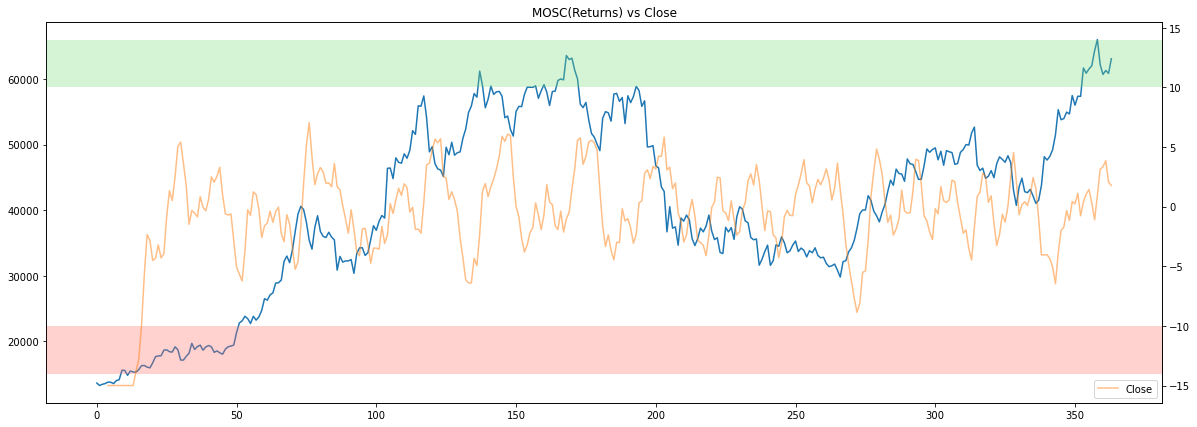

In [8]:
plot_osc_on_normalised("mosc", btc)

### SHI - Simple Harmonic Index

Normal


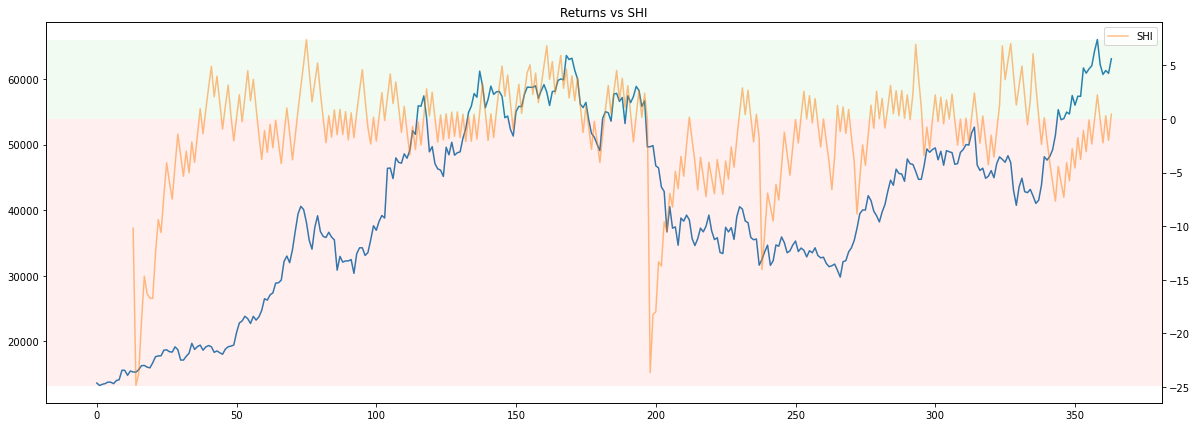

BOXCOX
Lambda value used for Transformation: -0.4296844977601439
Lambda value used for Transformation: 1.789003078068132


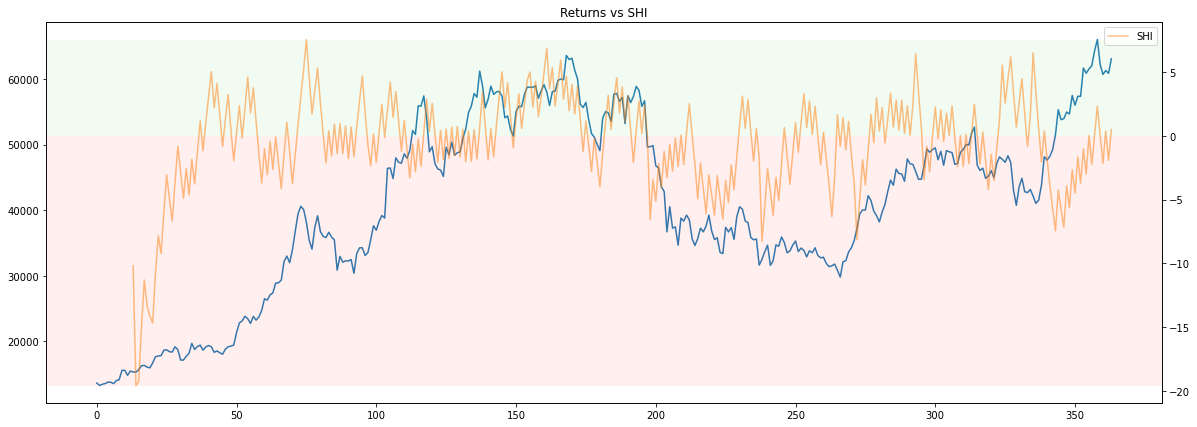

In [9]:
plot_osc_on_normalised("shi", btc)

### SHO - Simple Harmonic Oscillator

![title](SHO_trends.PNG)

Normal


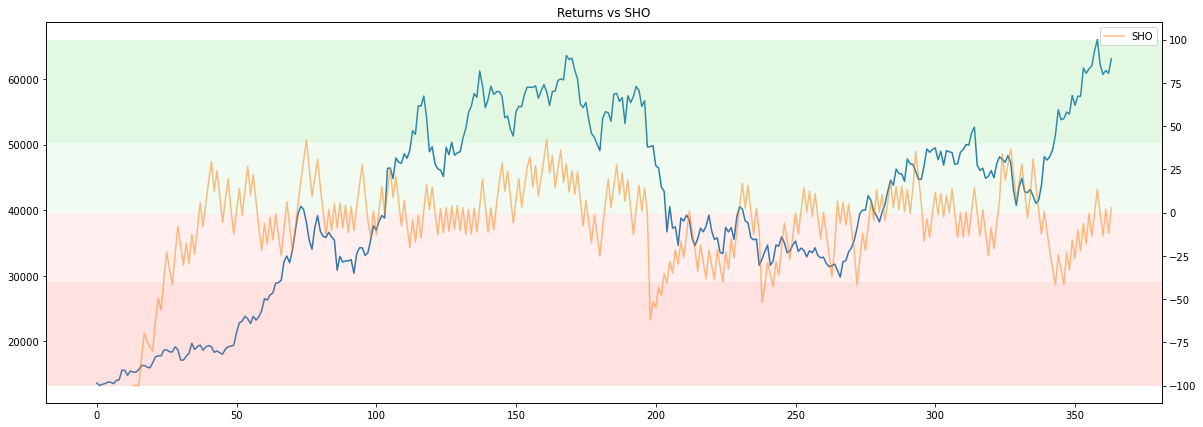

BOXCOX
Lambda value used for Transformation: -0.4296844977601439
Lambda value used for Transformation: 1.789003078068132


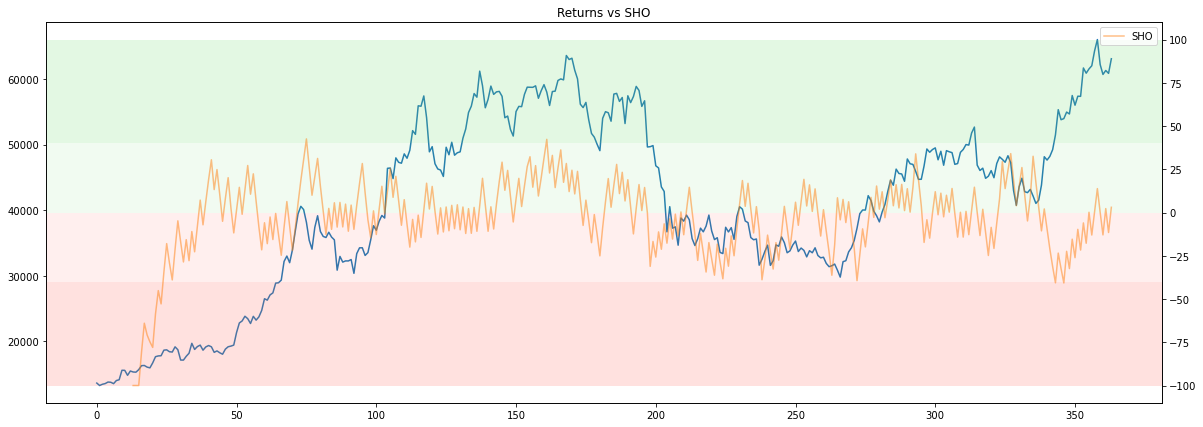

In [10]:
plot_osc_on_normalised("sho", btc)